In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [3]:
img_size = 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

In [ ]:
trainset = torchvision.datasets.ImageFolder(root='train/' , transform=transform)
testset = torchvision.datasets.ImageFolder(root='test/' , transform=transform)


In [21]:
trainset.classes

['pizza', 'steak', 'sushi']

In [15]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset , 32 , shuffle= True)
testloader = DataLoader(testset , 32 , shuffle= True)
trainloader , testloader

(<torch.utils.data.dataloader.DataLoader at 0x193d74a5150>,
 <torch.utils.data.dataloader.DataLoader at 0x193d7559c50>)

In [17]:
image_batch, label_batch = next(iter(trainloader))

image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

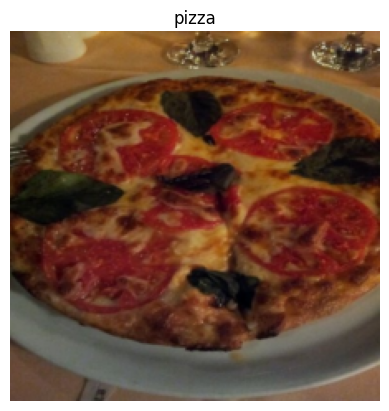

In [22]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(trainset.classes[label])
plt.axis(False)